In [47]:
%pip install torch torchvision --upgrade

  Using cached torch-2.8.0-cp313-none-macosx_11_0_arm64.whl.metadata (30 kB)
  Using cached torchvision-0.23.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.1 kB)
Using cached torch-2.8.0-cp313-none-macosx_11_0_arm64.whl (73.6 MB)
Using cached torchvision-0.23.0-cp313-cp313-macosx_11_0_arm64.whl (1.9 MB)
  Attempting uninstall: torch
    Found existing installation: torch 2.7.1
    Uninstalling torch-2.7.1:━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [torch]
      Successfully uninstalled torch-2.7.1━━━━━━━━━━━━ 0/2 [torch]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [torchvision] 1/2 [torchvision]

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [49]:
import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("iabhishekofficial/mobile-price-classification")

print("Path to dataset files:", path)

Path to dataset files: /Users/7n100489/.cache/kagglehub/datasets/iabhishekofficial/mobile-price-classification/versions/1


In [50]:
import pandas as pd

train = pd.read_csv(os.path.join(path, "train.csv"))
test = pd.read_csv(os.path.join(path, "test.csv"))

print(train.head())
print(test.head())

   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  price_

#### CSV Dataset

In [51]:
# Load mobile price dataset into dataframe
mobile_df = pd.read_csv(os.path.join(path, "train.csv")).dropna()
print(mobile_df.price_range.unique())
mobile_df.head()

[1 2 3 0]


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [52]:
# Seperate features and target
mb_X = mobile_df.drop(columns=['price_range']).values.astype(np.float32)
mb_y = mobile_df.price_range.values

# Standardize features
scaler = StandardScaler()
mb_X = scaler.fit_transform(mb_X)
# ^^^^^^^^

# Convert to tensors
mb_X = torch.tensor(mb_X)
mb_y = torch.tensor(mb_y)

# Create train and test datasets
mb_train_set = TensorDataset(mb_X, mb_y)
train_split = 0.8
mb_train_size = int(train_split * len(mb_train_set))
mb_test_size = len(mb_train_set) - mb_train_size
mb_train_set, mb_test_set = torch.utils.data.random_split(mb_train_set, [mb_train_size, mb_test_size])

# Create dataloaders
mb_train_loader = DataLoader(mb_train_set, batch_size=16, shuffle=True)
mb_test_loader = DataLoader(mb_test_set, batch_size=16, shuffle=True)

print(len(mb_train_set), len(mb_test_set))
print(len(mb_train_loader), len(mb_test_loader))

1600 400
100 25


#### Functions and Models for use

In [53]:
class MLP_CSV(nn.Module):
    def __init__(self):
        super(MLP_CSV, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=20, out_features=128), # 20 input features
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
        )
        self.out = nn.Linear(in_features=32, out_features=4)  # 4 output for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

class MLP_MNIST(nn.Module):
    def __init__(self):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8, out_features=32), # 8*8 = 64 resized input pixels
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=32, out_features=24),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=24, out_features=16),
            nn.ReLU(),
        )
        self.out = nn.Linear(in_features=16, out_features=10)  # 10 output for numbers

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

In [54]:
def training_loop(train_dl, test_dl, model, n_epochs=200):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Your optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    # ^^^^^^^^

    n_show_loss = n_epochs // 10 if n_epochs > 10 else 1
    train_history = {"train_loss":[], "validate_loss":[],
                     "train_acc":[], "validate_acc":[]}
    # Begin training loop
    for epoch in range(n_epochs):
        # Train loop
        train_loss, train_correct = 0, 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            # This is your training loss calculation
            loss = loss_fn(y_pred, y_t)
            loss.backward()
            # ^^^^^^^^
            optimizer.step()
            train_loss += loss.item()
            train_correct += (y_pred.argmax(1) == y_t).float().sum().item()
        train_history["train_loss"].append(train_loss / len(train_dl))
        train_history["train_acc"].append(train_correct / len(train_dl.dataset))

        # Test loop
        valid_loss, valid_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X_v, y_v in test_dl:
                X_v, y_v = X_v.to(device), y_v.to(device)
                y_predv = model(X_v)
                vloss = loss_fn(y_predv.squeeze(), y_v.squeeze())
                valid_loss += vloss.item()
                valid_correct += (y_predv.argmax(1) == y_v).float().sum().item()
        train_history["validate_loss"].append(valid_loss / len(test_dl))
        train_history["validate_acc"].append(valid_correct / len(test_dl.dataset))

        if ((epoch+1) % n_show_loss == 0) or (epoch == n_epochs-1):
            print(f"Epochs {epoch+1}".ljust(12),
                  f"train loss {train_history['train_loss'][-1]:.6f}",
                  f"valid loss {train_history['validate_loss'][-1]:.6f}",
                  f"train acc {train_history['train_acc'][-1]:.6f}",
                  f"valid acc {train_history['validate_acc'][-1]:.6f}")

    return train_history

def plot_result(history, title="Train vs Validation"):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle(title)
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()


----
## HW
----
### - CSV Dataset
Mobile price dataset ที่กำหนดมีข้อมูลเบื้องต้น ดังนี้
- จำนวน Features = 20 (RAM, Internal memory, Battery, ...)
- Target คือ `price_range` โดยมีทั้งหมด 4 ค่า คือ 0, 1, 2, 3 (Low cost, Medium cost, High cost, Very high cost)

> กำหนดให้ใช้โมเดล `MLP_CSV` เป็นต้นแบบ การ train ให้ใช้จำนวน `epochs` = 200, `optimizer` = Adam, `learning_rate` = 0.0001, `train_split` = 0.8, `batch_size` = 16, ไม่ใช้ Learning rate scheduler

'

1.) ให้ทดลอง train โมเดลโดยใช้ training loop ที่ให้มาหรือเขียนขึ้นเอง แบบธรรมดาไม่มีการปรับเพิ่มเติม ใช้เพื่อเป็นผลลัพธ์ Baseline สำหรับข้อต่อ ๆ ไป

- > แคปรูปผลลัพธ์ใหม่ 1 รูป

2.) ให้ทดลอง train โมเดลโดยใช้ L2 Regularizer เพิ่มในข้อ 1.) รวมทั้งหมด 2 แบบ คือ
  1. ใช้ L2 แบบ Marginal loss โดย `lambda` = [0.03, 0.01, 0.005] (เพิ่ม L2 loss ใน Training loop)
  2. ใช้ L2 แบบ Weight decay โดย `weight_decay` = [0.06, 0.01, 0.005] (ปรับ param ใน `optimizer`)

- > แคปรูปผลลัพธ์ใหม่ทั้งหมด 6 รูป พร้อมกับแสดงส่วนที่แก้ไขเพื่อทำ Marginal loss ภายใน Training loop และ วิเคราะห์เปรียบเทียบผลลัพธ์ที่ได้ทั้งหมดกับข้อ 1.)

3.) ให้ทดลอง train โมเดลโดยใช้ Dropout เพิ่มในข้อ 1.) ภายในชั้น fc1, fc2 และ fc3 และแทนค่า `p` ในแต่ละชั้นเป็นค่าดังต่อไปนี้
  1. fc1, fc2, fc3 = 0.5, 0.3, 0.2
  2. fc1, fc2, fc3 = 0.3, 0.2, 0.1
  3. fc1, fc2, fc3 = 0.2, 0.2, 0.2

- > แคปรูปผลลัพธ์ใหม่ทั้งหมด 3 รูป และ วิเคราะห์เปรียบเทียบผลลัพธ์ที่ได้กับข้อ 1.)

4.) ให้ทดลอง train โมเดล `MLP_CSV` ต้นแบบจากข้อ 1.) อีกครั้ง พร้อมกับ train โมเดลที่ใช้ BatchNorm เพิ่มในข้อ 1.) ภายในชั้น fc1, fc2 และ fc3 (ใช้ `nn.BatchNorm1d`) แต่จะมีการปรับในส่วนการเตรียม Mobile price Dataset ดังนี้
  1. โมเดลที่ใช้ BatchNorm ใช้ Dataset ที่ **ผ่าน** การทำ Standardized ด้วย `StandardScaler()` เทียบกับผลลัพธ์ข้อ 1.)
  2. โมเดล `MLP_CSV` ต้นแบบจากข้อ 1.) ใช้ Dataset ที่ **ไม่ผ่าน** การทำ Standardized
  3. โมเดลที่ใช้ BatchNorm ใช้ Dataset ที่ **ไม่ผ่าน** การทำ Standardized เทียบกับผลลัพธ์ข้อ 4.2)

- > แคปรูปผลลัพธ์ใหม่ทั้งหมด 3 รูป และ วิเคราะห์เปรียบเทียบผลลัพธ์ที่ได้

'

----

### - Torchvision Dataset

MNIST dataset จาก torchvision
- ภาพตัวเลขเขียนด้วยลายมือ
- ขนาด 28x28 pixel จะได้จำนวน features = 784
- Target = เลข 0 - 9 (10 ตัว)

```python
import torchvision
from torchvision import transforms
from torchvision.transforms import v2
import ...

# Your own transform
transforms = v2.Compose([
                v2.ToImage(),
                v2.ToDtype(torch.float32, scale=True),
                ...,
                ...])

# Optimizer, criterion (loss), and other hyper-pars
# model = ...
# optimizer = ...
# criterion = ...
# batch_size = ...
# scheduler = ...
# other = ...

# Download train-valid(test) Dataset
mnist_train_data = torchvision.datasets.MNIST('./Image/train_directory/', transform=transforms, download=True, train=True)
mnist_train_loader = torch.utils.data.DataLoader(mnist_train_data, batch_size=batch_size, shuffle=True)

mnist_test_data = torchvision.datasets.MNIST('./Image/test_directory/', transform=transforms, download=True, train=False)
mnist_valid_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=True)

# training loop
for epoch in range(epochs):
    model.train()
    # ...
    
    for inputs, labels in mnist_train_loader:
    # or
    for i, (inputs, labels) in enumerate(mnist_train_loader):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      # ...update...

    # Optional
    model.eval()
    with torch.no_grad():
      for vinputs, vlabels in mnist_valid_loader:
      # or
      for j, (vinputs, vlabels) in enumerate(mnist_valid_loader):
      voutputs = model(vinputs)
      loss = criterion(voutputs, vlabels)
      # ...non-update...

```

'

5.) ให้ทำการสร้าง Dataset ที่ใช้การ `transforms` เพิ่มเติมจากที่กำหนดไว้ โดยให้ลดขนาดภาพลงเหลือ 8x8 pixels (64 features) และเพิ่มการ Transform อีกอย่างน้อย 1 แบบ พร้อมกับสร้าง Dataloaders ที่มีจำนวน train : test = 80 : 20 ของจำนวน Dataset ทั้งหมดและใช้ `batch_size` = 16
* > แคปรูปส่วนกำหนดการ transforms และการทำ Dataloaders

ุ6.) ให้ทดลอง train โมเดล `MLP_MNIST` ต้นแบบที่กำหนด และ train โมเดลที่นักศึกษาออกแบบเอง (หรือเพิ่มต่อจากต้นแบบก็ได้) โดยกำหนดให้เพิ่มส่วนเทคนิคการใช้ L2 Regularizer, Dropout และ BatchNorm ภายในโมเดลที่ออกแบบเอง (เลือกอย่างน้อย 2 เทคนิค จะใส่ในทุก Hidden layers หรือไม่ก็ได้)

กำหนดไว้ว่าโมเดลที่นักศึกษาออกแบบ จะสามารถปรับจำนวน features ภายในได้อิสระ แต่ต้องมีจำนวน Hidden layers เท่ากับ `MLP_MNIST` ต้นแบบ และกำหนดการ train จะต้องใช้จำนวน `epochs` เท่ากัน โดยเลือกเองให้ <= 50, `optimizer` เลือกเอง และสามารถใช้ Learning rate scheduler ได้

* > จงทดลองหาผลลัพธ์การทำงาน ที่ทำให้ได้ประสิทธิภาพสูงกว่า `MLP_MNIST` ต้นแบบ เช่น Accuracy สูงกว่าเดิม
>
> แคปรูปผลลัพธ์การทำงาน โครงสร้างโมเดลสุดท้าย และอธิบายว่าใช้เทคนิคอะไร ทำอย่างไรบ้างที่ทำให้ได้ประสิทธิภาพสูงขึ้น

# 1. Baseline

Epochs 20    train loss 0.162042 valid loss 0.208638 train acc 0.955000 valid acc 0.925000
Epochs 40    train loss 0.059625 valid loss 0.178606 train acc 0.992500 valid acc 0.920000
Epochs 60    train loss 0.023380 valid loss 0.199258 train acc 1.000000 valid acc 0.927500
Epochs 80    train loss 0.008251 valid loss 0.234624 train acc 1.000000 valid acc 0.920000
Epochs 100   train loss 0.002776 valid loss 0.273678 train acc 1.000000 valid acc 0.920000
Epochs 120   train loss 0.000885 valid loss 0.321429 train acc 1.000000 valid acc 0.920000
Epochs 140   train loss 0.000293 valid loss 0.367807 train acc 1.000000 valid acc 0.920000
Epochs 160   train loss 0.000093 valid loss 0.410167 train acc 1.000000 valid acc 0.917500
Epochs 180   train loss 0.000030 valid loss 0.459063 train acc 1.000000 valid acc 0.917500
Epochs 200   train loss 0.000010 valid loss 0.502360 train acc 1.000000 valid acc 0.917500


/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


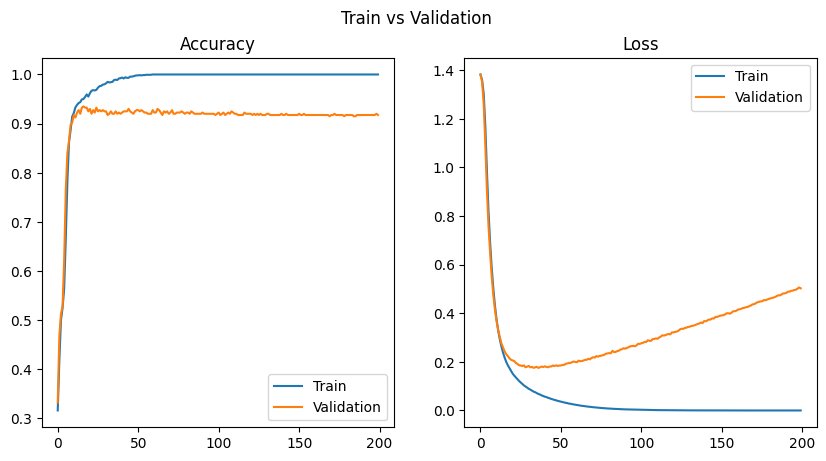

In [55]:
np.random.seed(42)
torch.manual_seed(42)

baseline_model = MLP_CSV()
base_history = training_loop(mb_train_loader, mb_test_loader, baseline_model, n_epochs=200)
plot_result(base_history)

# 2. L2 Regularization


Training with L2 lambda = 0.03
------------------------------
Epochs 20    train loss 1.177784 valid loss 1.170990 train acc 0.679375 valid acc 0.715000
Epochs 40    train loss 0.993757 valid loss 0.991643 train acc 0.912500 valid acc 0.930000
Epochs 60    train loss 0.968252 valid loss 0.969974 train acc 0.945625 valid acc 0.937500
Epochs 80    train loss 0.963348 valid loss 0.958474 train acc 0.947500 valid acc 0.947500
Epochs 100   train loss 0.960581 valid loss 0.956610 train acc 0.944375 valid acc 0.950000
Epochs 120   train loss 0.959372 valid loss 0.953935 train acc 0.939375 valid acc 0.952500
Epochs 140   train loss 0.958344 valid loss 0.953267 train acc 0.951875 valid acc 0.950000
Epochs 160   train loss 0.957397 valid loss 0.952395 train acc 0.940625 valid acc 0.955000
Epochs 180   train loss 0.955678 valid loss 0.953863 train acc 0.945625 valid acc 0.957500
Epochs 200   train loss 0.955765 valid loss 0.950389 train acc 0.945000 valid acc 0.950000

Training with L2 lambda = 

/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Epochs 20    train loss 0.697970 valid loss 0.713686 train acc 0.958750 valid acc 0.947500
Epochs 40    train loss 0.573618 valid loss 0.614990 train acc 0.984375 valid acc 0.945000
Epochs 60    train loss 0.526465 valid loss 0.576233 train acc 0.989375 valid acc 0.947500
Epochs 80    train loss 0.503621 valid loss 0.556857 train acc 0.994375 valid acc 0.940000
Epochs 100   train loss 0.491219 valid loss 0.546089 train acc 0.995000 valid acc 0.947500
Epochs 120   train loss 0.483302 valid loss 0.539107 train acc 0.996875 valid acc 0.947500
Epochs 140   train loss 0.478406 valid loss 0.536941 train acc 0.993750 valid acc 0.945000
Epochs 160   train loss 0.474968 valid loss 0.537546 train acc 0.997500 valid acc 0.937500
Epochs 180   train loss 0.470954 valid loss 0.529509 train acc 0.996250 valid acc 0.940000
Epochs 200   train loss 0.467772 valid loss 0.524331 train acc 0.995625 valid acc 0.942500

Training with L2 lambda = 0.005
------------------------------
Epochs 20    train loss 0.

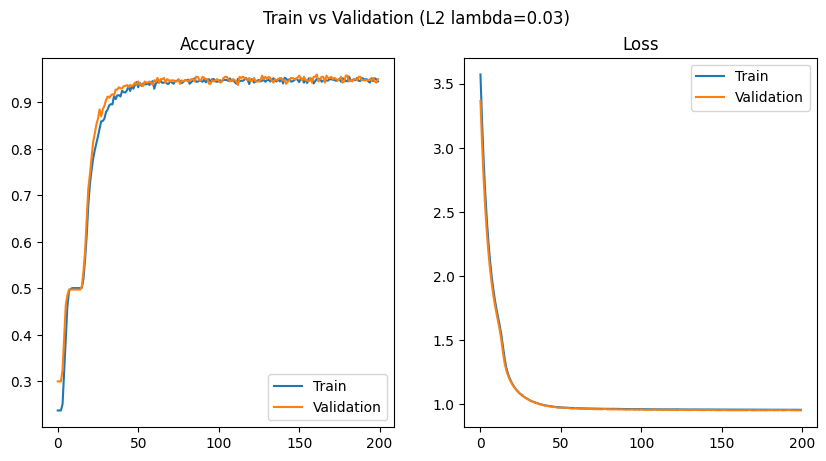

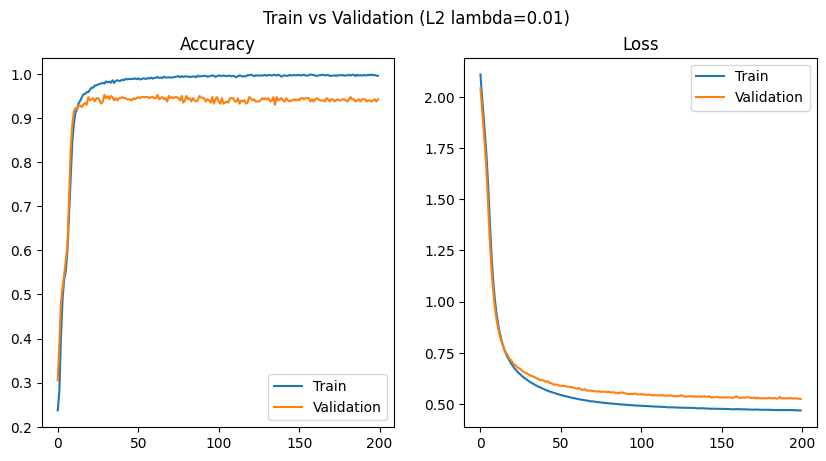

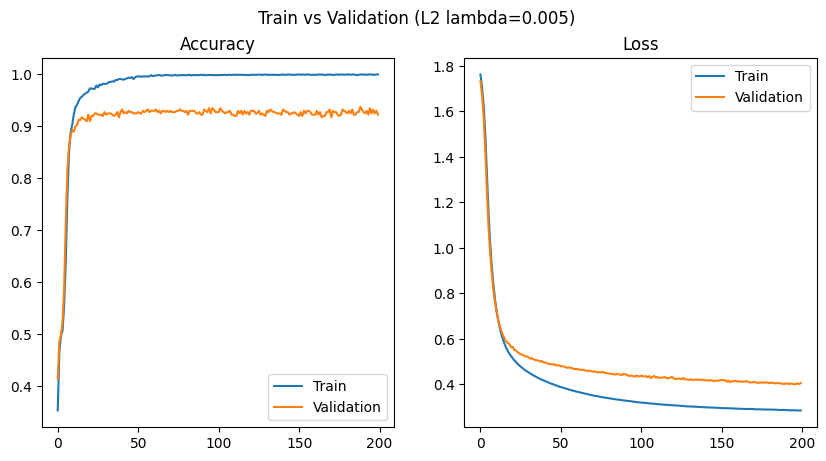

In [56]:
# A. Marginal L2

lambda_ = [0.03, 0.01, 0.005]


def training_loop_with_custom_L2(train_dl, test_dl, model, n_epochs=200, lambda_=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Your optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.CrossEntropyLoss()
    # ^^^^^^^^

    n_show_loss = n_epochs // 10 if n_epochs > 10 else 1
    train_history = {
        "train_loss": [],
        "validate_loss": [],
        "train_acc": [],
        "validate_acc": [],
    }
    # Begin training loop
    for epoch in range(n_epochs):
        # Train loop
        train_loss, train_correct = 0, 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            # This is your training loss calculation
            loss = loss_fn(y_pred, y_t)

            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            total_loss = loss + lambda_ * l2_norm

            total_loss.backward()
            # ^^^^^^^^
            optimizer.step()
            train_loss += total_loss.item()
            train_correct += (y_pred.argmax(1) == y_t).float().sum().item()
        train_history["train_loss"].append(train_loss / len(train_dl))
        train_history["train_acc"].append(train_correct / len(train_dl.dataset))

        # Test loop
        valid_loss, valid_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X_v, y_v in test_dl:
                X_v, y_v = X_v.to(device), y_v.to(device)
                y_predv = model(X_v)
                vloss = loss_fn(y_predv.squeeze(), y_v.squeeze())

                l2_val_loss = sum(p.pow(2.0).sum() for p in model.parameters())
                total_val_loss = vloss + lambda_ * l2_val_loss

                valid_loss += total_val_loss.item()
                valid_correct += (y_predv.argmax(1) == y_v).float().sum().item()
        train_history["validate_loss"].append(valid_loss / len(test_dl))
        train_history["validate_acc"].append(valid_correct / len(test_dl.dataset))

        if ((epoch + 1) % n_show_loss == 0) or (epoch == n_epochs - 1):
            print(
                f"Epochs {epoch + 1}".ljust(12),
                f"train loss {train_history['train_loss'][-1]:.6f}",
                f"valid loss {train_history['validate_loss'][-1]:.6f}",
                f"train acc {train_history['train_acc'][-1]:.6f}",
                f"valid acc {train_history['validate_acc'][-1]:.6f}",
            )

    return train_history


for l2 in lambda_:
    print(f"\nTraining with L2 lambda = {l2}\n" + "-" * 30)
    model_l2 = MLP_CSV()
    l2_history = training_loop_with_custom_L2(
        mb_train_loader, mb_test_loader, model_l2, n_epochs=200, lambda_=l2
    )
    plot_result(l2_history, title=f"Train vs Validation (L2 lambda={l2})")


Training with weight decay: 0.06
Epochs 20    train loss 0.744022 valid loss 0.731662 train acc 0.685625 valid acc 0.712500
Epochs 40    train loss 0.466286 valid loss 0.463670 train acc 0.916875 valid acc 0.920000
Epochs 60    train loss 0.404765 valid loss 0.401185 train acc 0.945000 valid acc 0.945000
Epochs 80    train loss 0.389595 valid loss 0.385287 train acc 0.948125 valid acc 0.950000
Epochs 100   train loss 0.385014 valid loss 0.380664 train acc 0.944375 valid acc 0.952500
Epochs 120   train loss 0.380609 valid loss 0.375884 train acc 0.948750 valid acc 0.945000
Epochs 140   train loss 0.378743 valid loss 0.377641 train acc 0.942500 valid acc 0.952500
Epochs 160   train loss 0.376826 valid loss 0.372637 train acc 0.945625 valid acc 0.952500
Epochs 180   train loss 0.375089 valid loss 0.370663 train acc 0.946875 valid acc 0.950000
Epochs 200   train loss 0.374377 valid loss 0.371089 train acc 0.950625 valid acc 0.947500

Training with weight decay: 0.01


/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Epochs 20    train loss 0.189212 valid loss 0.215153 train acc 0.968125 valid acc 0.942500
Epochs 40    train loss 0.109420 valid loss 0.168142 train acc 0.992500 valid acc 0.955000
Epochs 60    train loss 0.085260 valid loss 0.163074 train acc 0.995625 valid acc 0.945000
Epochs 80    train loss 0.073013 valid loss 0.159596 train acc 0.998750 valid acc 0.935000
Epochs 100   train loss 0.065535 valid loss 0.157724 train acc 0.999375 valid acc 0.937500
Epochs 120   train loss 0.061277 valid loss 0.158422 train acc 0.999375 valid acc 0.935000
Epochs 140   train loss 0.058928 valid loss 0.157096 train acc 0.999375 valid acc 0.937500
Epochs 160   train loss 0.057313 valid loss 0.161745 train acc 1.000000 valid acc 0.942500
Epochs 180   train loss 0.055955 valid loss 0.162647 train acc 1.000000 valid acc 0.940000
Epochs 200   train loss 0.055818 valid loss 0.160558 train acc 0.999375 valid acc 0.937500

Training with weight decay: 0.005
Epochs 20    train loss 0.183569 valid loss 0.205880 tr

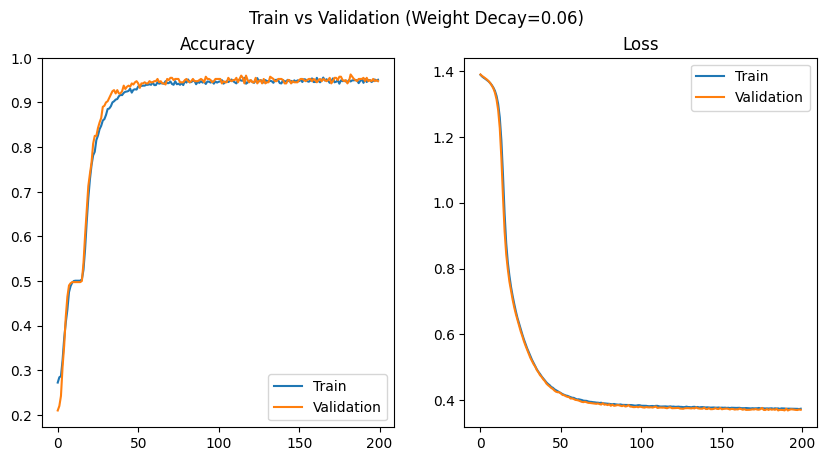

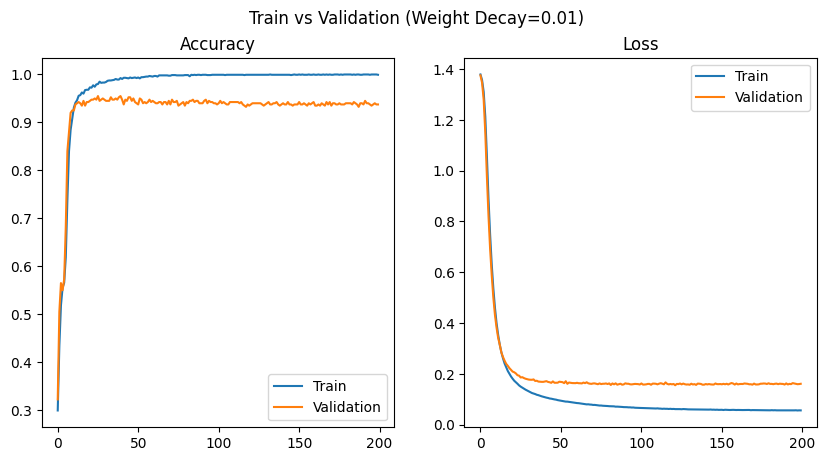

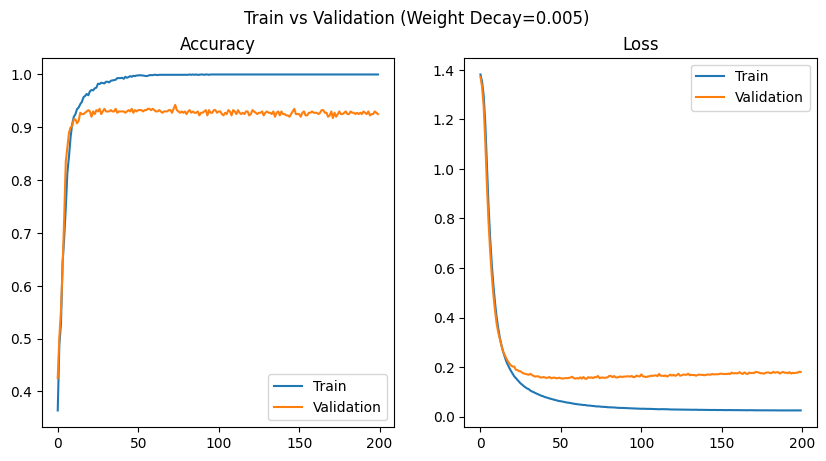

In [57]:
# B. Weight Decay (L2 Regularization) in Optimizer
weight_decay = [0.06, 0.01, 0.005]


def training_loop_with_custom_weight_decay(
    train_dl, test_dl, model, n_epochs=200, weight_decay=0.01
):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Your optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=weight_decay)
    loss_fn = nn.CrossEntropyLoss()
    # ^^^^^^^^

    n_show_loss = n_epochs // 10 if n_epochs > 10 else 1
    train_history = {
        "train_loss": [],
        "validate_loss": [],
        "train_acc": [],
        "validate_acc": [],
    }
    # Begin training loop
    for epoch in range(n_epochs):
        # Train loop
        train_loss, train_correct = 0, 0
        model.train(True)
        for X_t, y_t in train_dl:
            X_t, y_t = X_t.to(device), y_t.to(device)
            optimizer.zero_grad()
            y_pred = model(X_t)
            # This is your training loss calculation
            loss = loss_fn(y_pred, y_t)
            loss.backward()
            # ^^^^^^^^
            optimizer.step()
            train_loss += loss.item()
            train_correct += (y_pred.argmax(1) == y_t).float().sum().item()
        train_history["train_loss"].append(train_loss / len(train_dl))
        train_history["train_acc"].append(train_correct / len(train_dl.dataset))

        # Test loop
        valid_loss, valid_correct = 0, 0
        model.eval()
        with torch.no_grad():
            for X_v, y_v in test_dl:
                X_v, y_v = X_v.to(device), y_v.to(device)
                y_predv = model(X_v)
                vloss = loss_fn(y_predv.squeeze(), y_v.squeeze())
                valid_loss += vloss.item()
                valid_correct += (y_predv.argmax(1) == y_v).float().sum().item()
        train_history["validate_loss"].append(valid_loss / len(test_dl))
        train_history["validate_acc"].append(valid_correct / len(test_dl.dataset))

        if ((epoch + 1) % n_show_loss == 0) or (epoch == n_epochs - 1):
            print(
                f"Epochs {epoch + 1}".ljust(12),
                f"train loss {train_history['train_loss'][-1]:.6f}",
                f"valid loss {train_history['validate_loss'][-1]:.6f}",
                f"train acc {train_history['train_acc'][-1]:.6f}",
                f"valid acc {train_history['validate_acc'][-1]:.6f}",
            )

    return train_history


for wd in weight_decay:
    print(f"\nTraining with weight decay: {wd}")
    model_wd = MLP_CSV()
    history_wd = training_loop_with_custom_weight_decay(
        mb_train_loader, mb_test_loader, model_wd, n_epochs=200, weight_decay=wd
    )
    plot_result(history_wd, title=f"Train vs Validation (Weight Decay={wd})")

# 3. Dropout

In [58]:
class MLP_CSV_DROPOUT(nn.Module):
    def __init__(self, p1, p2, p3):
        super(MLP_CSV_DROPOUT, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=20, out_features=128), # 20 input features
            nn.ReLU(),
            nn.Dropout(p=p1),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=p2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout(p=p3),
        )
        self.out = nn.Linear(in_features=32, out_features=4)  # 4 output for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

Training model with dropout p = [0.5, 0.3, 0.2]
Epochs 20    train loss 0.613267 valid loss 0.433000 train acc 0.732500 valid acc 0.890000
Epochs 40    train loss 0.422149 valid loss 0.256306 train acc 0.815000 valid acc 0.922500
Epochs 60    train loss 0.347304 valid loss 0.216261 train acc 0.856875 valid acc 0.930000
Epochs 80    train loss 0.307438 valid loss 0.193356 train acc 0.868125 valid acc 0.932500
Epochs 100   train loss 0.262332 valid loss 0.175126 train acc 0.894375 valid acc 0.932500
Epochs 120   train loss 0.248132 valid loss 0.176253 train acc 0.902500 valid acc 0.930000
Epochs 140   train loss 0.248152 valid loss 0.178450 train acc 0.905625 valid acc 0.925000
Epochs 160   train loss 0.194375 valid loss 0.170215 train acc 0.920625 valid acc 0.922500
Epochs 180   train loss 0.173564 valid loss 0.171027 train acc 0.931250 valid acc 0.925000
Epochs 200   train loss 0.176360 valid loss 0.179310 train acc 0.929375 valid acc 0.922500
Training model with dropout p = [0.3, 0.2,

/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Epochs 20    train loss 0.411211 valid loss 0.299362 train acc 0.831250 valid acc 0.917500
Epochs 40    train loss 0.295312 valid loss 0.199723 train acc 0.871875 valid acc 0.920000
Epochs 60    train loss 0.236966 valid loss 0.181638 train acc 0.902500 valid acc 0.937500
Epochs 80    train loss 0.178468 valid loss 0.172486 train acc 0.931250 valid acc 0.925000
Epochs 100   train loss 0.168453 valid loss 0.168354 train acc 0.930625 valid acc 0.925000
Epochs 120   train loss 0.163418 valid loss 0.175304 train acc 0.935000 valid acc 0.922500
Epochs 140   train loss 0.136166 valid loss 0.176554 train acc 0.947500 valid acc 0.917500
Epochs 160   train loss 0.102009 valid loss 0.180401 train acc 0.964375 valid acc 0.922500
Epochs 180   train loss 0.092141 valid loss 0.194507 train acc 0.965000 valid acc 0.922500
Epochs 200   train loss 0.102487 valid loss 0.197306 train acc 0.961250 valid acc 0.922500
Training model with dropout p = [0.2, 0.2, 0.2]
Epochs 20    train loss 0.380140 valid los

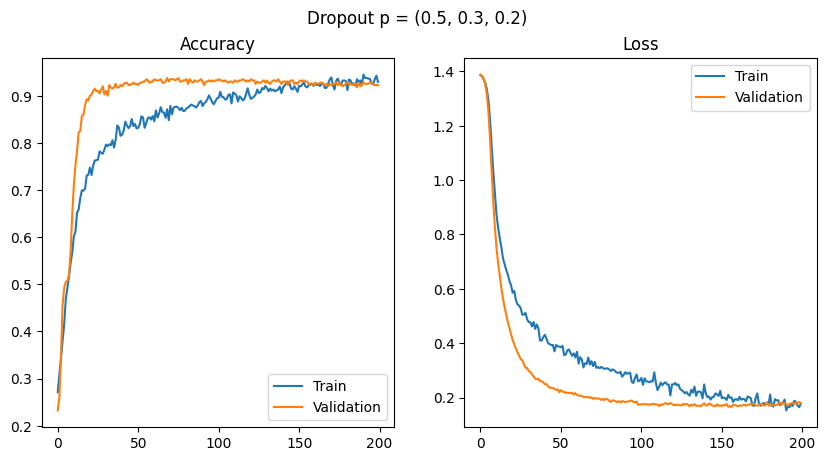

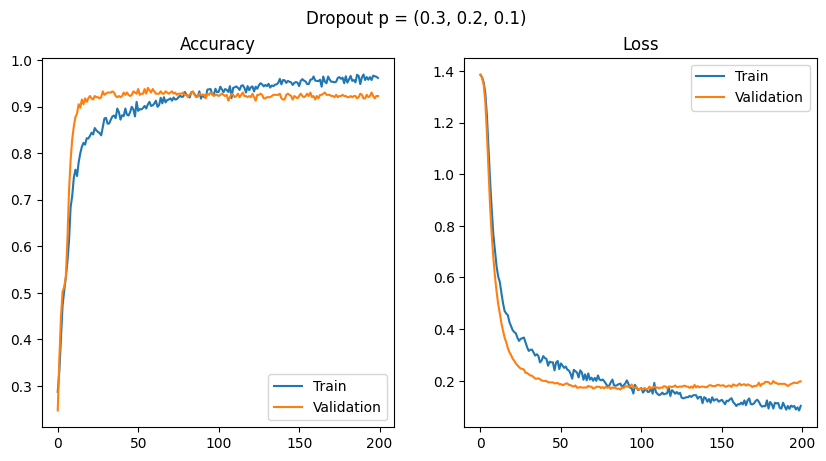

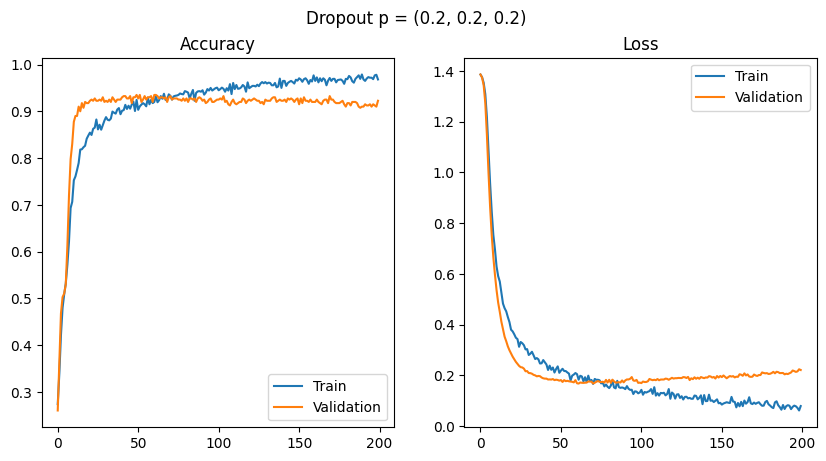

In [59]:
p = [
    [0.5, 0.3, 0.2],
    [0.3, 0.2, 0.1],
    [0.2, 0.2, 0.2],
]

for i in range(3):
    print(f"Training model with dropout p = {p[i]}")
    np.random.seed(42)
    torch.manual_seed(42)
    dropout_model = MLP_CSV_DROPOUT(p[i][0], p[i][1], p[i][2])
    dropout_history = training_loop(mb_train_loader, mb_test_loader, dropout_model, n_epochs=200)
    plot_result(dropout_history, title=f"Dropout p = ({p[i][0]}, {p[i][1]}, {p[i][2]})")

# 4. BatchNorm

In [60]:
class MLP_CSV_BATCHNORM(nn.Module):
    def __init__(self):
        super(MLP_CSV_BATCHNORM, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=20, out_features=128), # 20 input features
            nn.BatchNorm1d(128) ,
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
        )
        self.out = nn.Linear(in_features=32, out_features=4)  # 4 output for classification

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

In [61]:
mb_raw_X = mobile_df.drop(columns=['price_range']).values.astype(np.float32)
mb_raw_y = mobile_df.price_range.values

# Convert to tensors
mb_raw_X = torch.tensor(mb_raw_X)
mb_raw_y = torch.tensor(mb_raw_y)

# Create train/test datasets
train_split = 0.8
mb_raw_dataset = TensorDataset(mb_raw_X, mb_raw_y)
mb_raw_train_size = int(train_split * len(mb_raw_dataset))
mb_raw_test_size = len(mb_raw_dataset) - mb_raw_train_size
mb_raw_train_set, mb_raw_test_set = torch.utils.data.random_split(
    mb_raw_dataset, [mb_raw_train_size, mb_raw_test_size]
)

mb_raw_train_loader = DataLoader(mb_raw_train_set, batch_size=16, shuffle=True)
mb_raw_test_loader = DataLoader(mb_raw_test_set, batch_size=16, shuffle=True)

print(len(mb_raw_train_set), len(mb_raw_test_set))

1600 400


4.1 BatchNorm with standardized data
Epochs 20    train loss 0.577749 valid loss 0.519736 train acc 0.798750 valid acc 0.852500
Epochs 40    train loss 0.408824 valid loss 0.381092 train acc 0.843750 valid acc 0.867500
Epochs 60    train loss 0.355502 valid loss 0.375661 train acc 0.866250 valid acc 0.850000
Epochs 80    train loss 0.351286 valid loss 0.449888 train acc 0.865625 valid acc 0.800000
Epochs 100   train loss 0.308664 valid loss 0.493095 train acc 0.890000 valid acc 0.787500
Epochs 120   train loss 0.253718 valid loss 0.441775 train acc 0.911875 valid acc 0.810000
Epochs 140   train loss 0.274389 valid loss 0.561942 train acc 0.901250 valid acc 0.772500
Epochs 160   train loss 0.241940 valid loss 0.481871 train acc 0.905625 valid acc 0.802500
Epochs 180   train loss 0.224709 valid loss 0.518931 train acc 0.924375 valid acc 0.800000
Epochs 200   train loss 0.205160 valid loss 0.498863 train acc 0.929375 valid acc 0.790000
4.2 MLP CSV with non-standardized data


/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Epochs 20    train loss 0.711683 valid loss 0.785440 train acc 0.681250 valid acc 0.612500
Epochs 40    train loss 0.617941 valid loss 0.680524 train acc 0.713125 valid acc 0.687500
Epochs 60    train loss 0.577516 valid loss 0.668919 train acc 0.733125 valid acc 0.695000
Epochs 80    train loss 0.551214 valid loss 0.747063 train acc 0.746875 valid acc 0.672500
Epochs 100   train loss 0.519531 valid loss 0.717680 train acc 0.768125 valid acc 0.690000
Epochs 120   train loss 0.496700 valid loss 0.807478 train acc 0.775000 valid acc 0.657500
Epochs 140   train loss 0.487405 valid loss 0.727736 train acc 0.780000 valid acc 0.700000
Epochs 160   train loss 0.454366 valid loss 0.668263 train acc 0.795625 valid acc 0.717500
Epochs 180   train loss 0.452016 valid loss 0.703571 train acc 0.799375 valid acc 0.697500
Epochs 200   train loss 0.440588 valid loss 0.795300 train acc 0.798750 valid acc 0.675000
4.3 BatchNorm with non-standardized data
Epochs 20    train loss 0.470472 valid loss 0.336

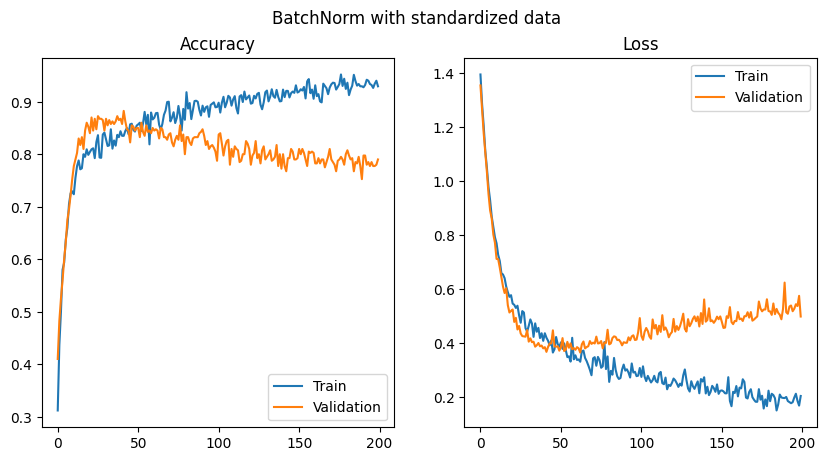

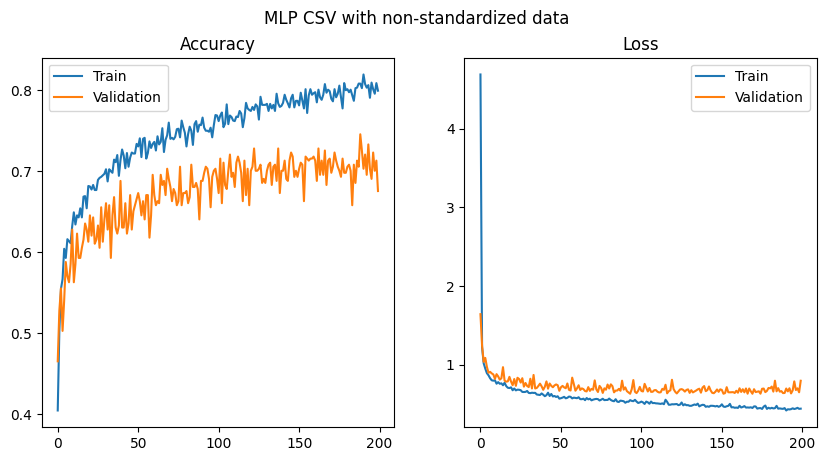

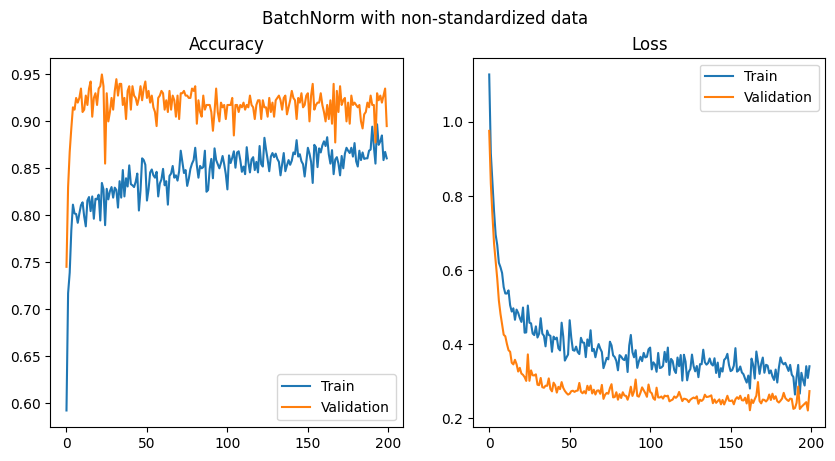

In [62]:
# BatchNorm with standardized data
print("4.1 BatchNorm with standardized data")
np.random.seed(42)
torch.manual_seed(42)
batchnorm_model = MLP_CSV_BATCHNORM()
batchnorm_history = training_loop(mb_train_loader, mb_test_loader, batchnorm_model, n_epochs=200)
plot_result(batchnorm_history, title="BatchNorm with standardized data")

# MLP CSV with non-standardized data
print("4.2 MLP CSV with non-standardized data")
np.random.seed(42)
torch.manual_seed(42)
mlp_model = MLP_CSV()
mlp_history = training_loop(mb_raw_train_loader, mb_raw_test_loader, mlp_model, n_epochs=200)
plot_result(mlp_history, title="MLP CSV with non-standardized data")

# BatchNorm with non-standardized data
print("4.3 BatchNorm with non-standardized data")
np.random.seed(42)
torch.manual_seed(42)
batchnorm_model = MLP_CSV_BATCHNORM()
batchnorm_history = training_loop(mb_raw_train_loader, mb_raw_test_loader, batchnorm_model, n_epochs=200)
plot_result(batchnorm_history, title="BatchNorm with non-standardized data")

# 5. Transform & Dataloaders

In [68]:
import torchvision
from torchvision import transforms
from torchvision.transforms import v2

mnist_transforms = v2.Compose(
    [
        v2.ToImage(),
        v2.Resize((8, 8)),
        v2.RandomHorizontalFlip(),
        v2.ToDtype(torch.float32, scale=True),
    ]
)

train_mnist = torchvision.datasets.MNIST(
    "./Image/mnist/", transform=mnist_transforms, download=True, train=True
)
test_mnist = torchvision.datasets.MNIST(
    "./Image/mnist/", transform=mnist_transforms, download=True, train=False
)
full_mnist = torch.utils.data.ConcatDataset([train_mnist, test_mnist])


batch_size = 16
train_size = int(0.8 * len(full_mnist))
test_size = len(full_mnist) - train_size

mnist_train_set, mnist_test_set = torch.utils.data.random_split(
    full_mnist, [train_size, test_size]
)

mnist_train_loader = torch.utils.data.DataLoader(
    mnist_train_set, batch_size=batch_size, shuffle=True
)

mnist_test_loader = torch.utils.data.DataLoader(
    mnist_test_set, batch_size=batch_size, shuffle=True
)

print(len(mnist_train_set), len(mnist_test_set))

56000 14000


# 6. MNIST Training

In [ ]:
class MLP_MNIST(nn.Module):
    def __init__(self):
        super(MLP_MNIST, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8, out_features=32), # 8*8 = 64 resized input pixels
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=32, out_features=24),
            nn.ReLU(),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=24, out_features=16),
            nn.ReLU(),
        )
        self.out = nn.Linear(in_features=16, out_features=10)  # 10 output for numbers

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

Epochs 3     train loss 0.987060 valid loss 0.887362 train acc 0.685839 valid acc 0.720286
Epochs 6     train loss 0.717062 valid loss 0.714951 train acc 0.762661 valid acc 0.767357
Epochs 9     train loss 0.637864 valid loss 0.643330 train acc 0.787429 valid acc 0.787571
Epochs 12    train loss 0.582025 valid loss 0.593666 train acc 0.806446 valid acc 0.802571
Epochs 15    train loss 0.541827 valid loss 0.554391 train acc 0.819429 valid acc 0.816714
Epochs 18    train loss 0.509300 valid loss 0.525123 train acc 0.830036 valid acc 0.826643
Epochs 21    train loss 0.484343 valid loss 0.496397 train acc 0.838214 valid acc 0.835643
Epochs 24    train loss 0.461990 valid loss 0.477722 train acc 0.846357 valid acc 0.842786
Epochs 27    train loss 0.442695 valid loss 0.458461 train acc 0.852196 valid acc 0.849929
Epochs 30    train loss 0.425771 valid loss 0.442649 train acc 0.859982 valid acc 0.853000


/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


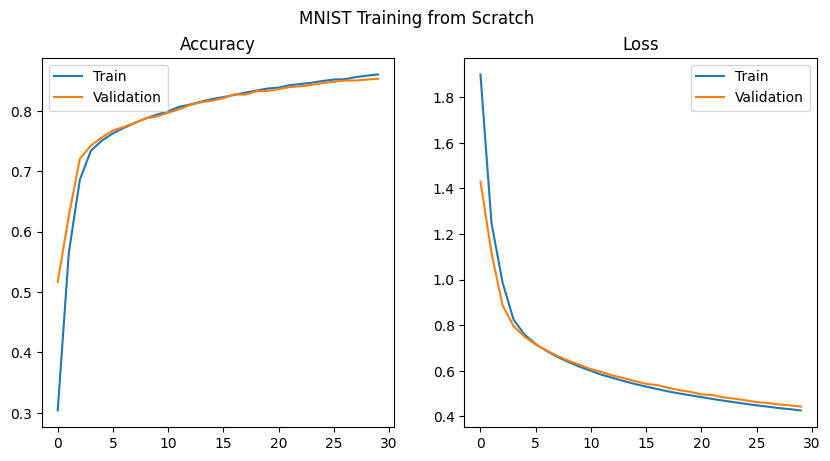

In [76]:
mnist_model = MLP_MNIST()
mnist_history = training_loop(mnist_train_loader, mnist_test_loader, mnist_model, n_epochs=30)
plot_result(mnist_history, title="MNIST Training from Scratch")

In [79]:
class IMPROVED_MLP_MNIST(nn.Module):
    def __init__(self):
        super(IMPROVED_MLP_MNIST, self).__init__()
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=8*8, out_features=64), # 8*8 = 64 resized input pixels
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=64, out_features=32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc3 = nn.Sequential(
            nn.Linear(in_features=32, out_features=16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.out = nn.Linear(in_features=16, out_features=10)  # 10 output for numbers

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.out(x)
        return x

Epochs 3     train loss 1.031201 valid loss 0.637009 train acc 0.671339 valid acc 0.829786
Epochs 6     train loss 0.834779 valid loss 0.444691 train acc 0.735482 valid acc 0.869286
Epochs 9     train loss 0.763294 valid loss 0.366038 train acc 0.762893 valid acc 0.895929
Epochs 12    train loss 0.714852 valid loss 0.328546 train acc 0.778875 valid acc 0.907286
Epochs 15    train loss 0.687911 valid loss 0.312895 train acc 0.787357 valid acc 0.909143
Epochs 18    train loss 0.660610 valid loss 0.290609 train acc 0.801679 valid acc 0.916000
Epochs 21    train loss 0.636541 valid loss 0.286229 train acc 0.808143 valid acc 0.916000
Epochs 24    train loss 0.632811 valid loss 0.272196 train acc 0.807946 valid acc 0.922429
Epochs 27    train loss 0.612688 valid loss 0.275221 train acc 0.815054 valid acc 0.918071
Epochs 30    train loss 0.609219 valid loss 0.275102 train acc 0.817679 valid acc 0.921143


/var/folders/bh/yxgmvcwn49390srvg5kl2d01f3vnyl/T/ipykernel_96459/1163574365.py:67: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


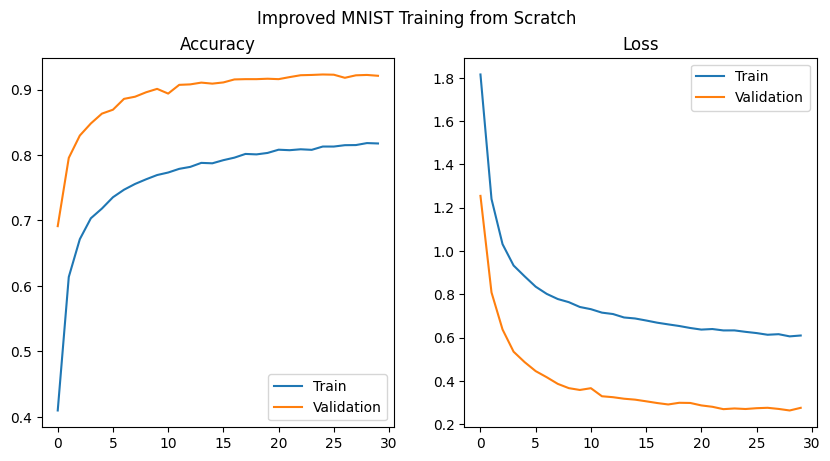

In [80]:
improved_mnist_model = IMPROVED_MLP_MNIST()
improved_mnist_history = training_loop(mnist_train_loader, mnist_test_loader, improved_mnist_model, n_epochs=30)
plot_result(improved_mnist_history, title="Improved MNIST Training from Scratch")